<a href="https://colab.research.google.com/github/shivamjha-9/e-wastecfy-ml/blob/main/Copy_of_week3report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B0  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations

In [4]:
from zipfile import ZipFile

zip_path = zip_path = zip_path = '/content/E-Waste classification dataset.zip'
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/e-waste-data')


In [5]:
import os

# Find all folders inside /content
for root, dirs, files in os.walk("/content"):
    for dirname in dirs:
        if dirname.lower() == "train":
            print("✅ Found train folder at:", os.path.join(root, dirname))


✅ Found train folder at: /content/e-waste-data/modified-dataset/train


In [6]:
import os

# Find paths of train, val, and test folders
for root, dirs, files in os.walk("/content"):
    for name in dirs:
        if name.lower() in ['train', 'val', 'test']:
            print(f"{name} folder found at: {os.path.join(root, name)}")

test folder found at: /content/e-waste-data/modified-dataset/test
train folder found at: /content/e-waste-data/modified-dataset/train
val folder found at: /content/e-waste-data/modified-dataset/val


In [7]:
trainpath = '/content/e-waste-data/modified-dataset/train'
validpath = '/content/e-waste-data/modified-dataset/val'
testpath  = '/content/e-waste-data/modified-dataset/test'

In [8]:
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.


In [9]:
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [10]:
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (128,128), batch_size = 32, validation_split= False)

Found 300 files belonging to 10 classes.


In [11]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)


10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


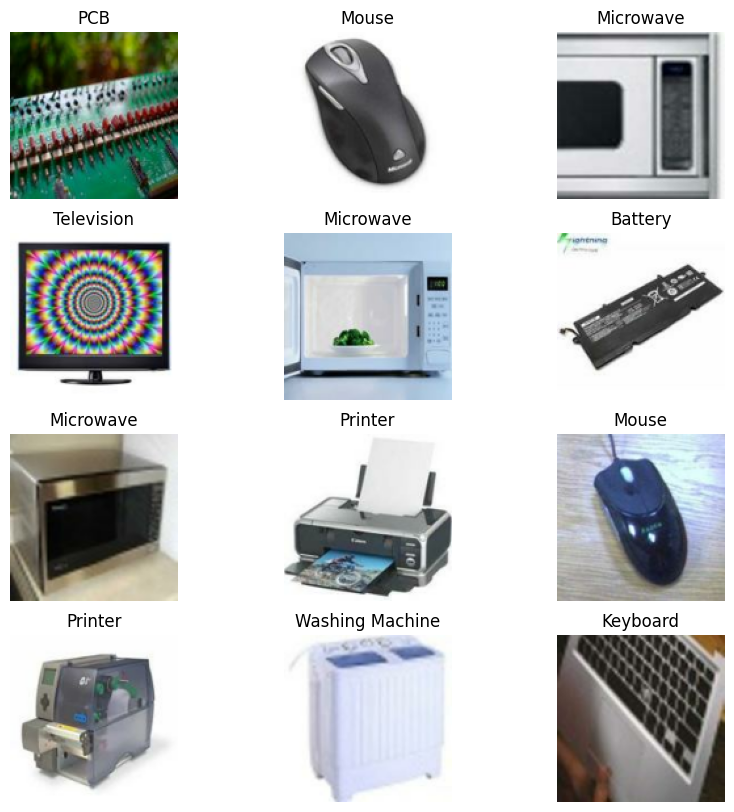

In [12]:
# Set the size of the entire figure (width=10, height=10 inches)
plt.figure(figsize=(10, 10))

# Take one batch from the dataset and iterate over the images and labels
for images, labels in datatrain.take(1):
    # Display the first 12 images from the batch
    for i in range(12):
        # Create a 4x3 grid of subplots and select the (i+1)th position
        ax = plt.subplot(4, 3, i + 1)

        # Display the image; convert the tensor to a NumPy array and ensure correct type
        plt.imshow(images[i].numpy().astype("uint8"))

        # Set the title of the subplot to the class name of the image
        plt.title(class_names[labels[i]])

        # Remove axis ticks and labels for clarity
        plt.axis("off")

In [13]:
import os
from collections import Counter

# Count the number of images in each class directory under the train folder
class_counts = Counter()

for class_name in os.listdir(trainpath):
    class_dir = os.path.join(trainpath, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))


In [14]:
    # Prepare data for plotting
    class_names = list(class_counts.keys())  # List of class names
    counts = list(class_counts.values())     # Corresponding counts for each class

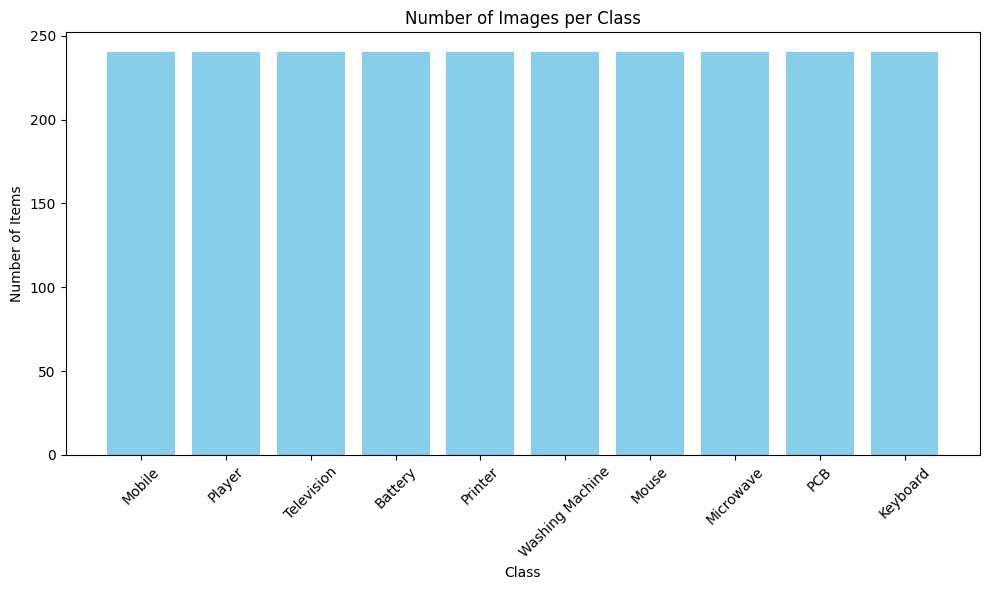

In [19]:
    # Define title for the plot
    title = "Number of Images per Class"

    # Create the bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(class_names, counts, color='skyblue')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot

In [24]:
def plot_class_distribution_from_dataset(dataset, class_names, title="Class Distribution"):
    """
    Plot class distribution from a tf.data.Dataset object.
    """
    label_counts = Counter()

    for _, labels in dataset.unbatch():
        label = int(labels.numpy()) if tf.rank(labels) == 0 else int(tf.argmax(labels).numpy())
        label_counts[label] += 1

    sorted_labels = sorted(label_counts.keys())
    counts = [label_counts[label] for label in sorted_labels]
    names = [class_names[label] for label in sorted_labels]

    plt.figure(figsize=(10, 6))
    plt.bar(names, counts, color='skyblue')
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()



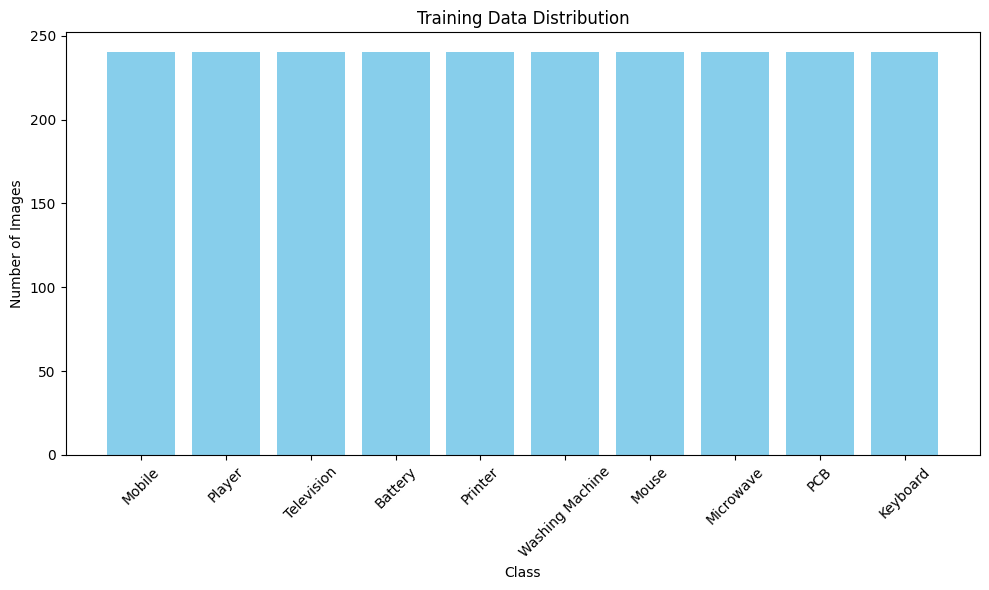

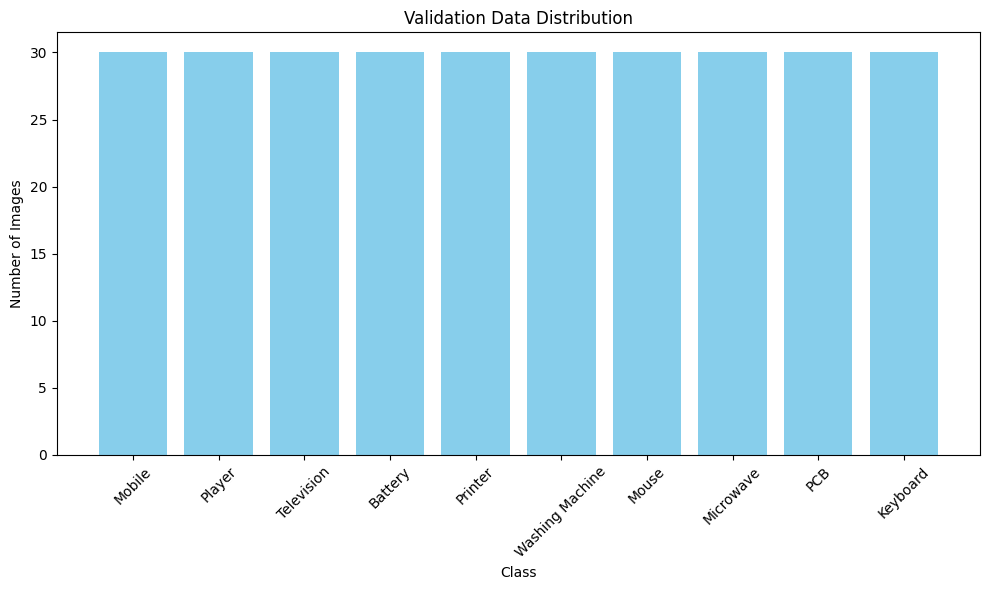

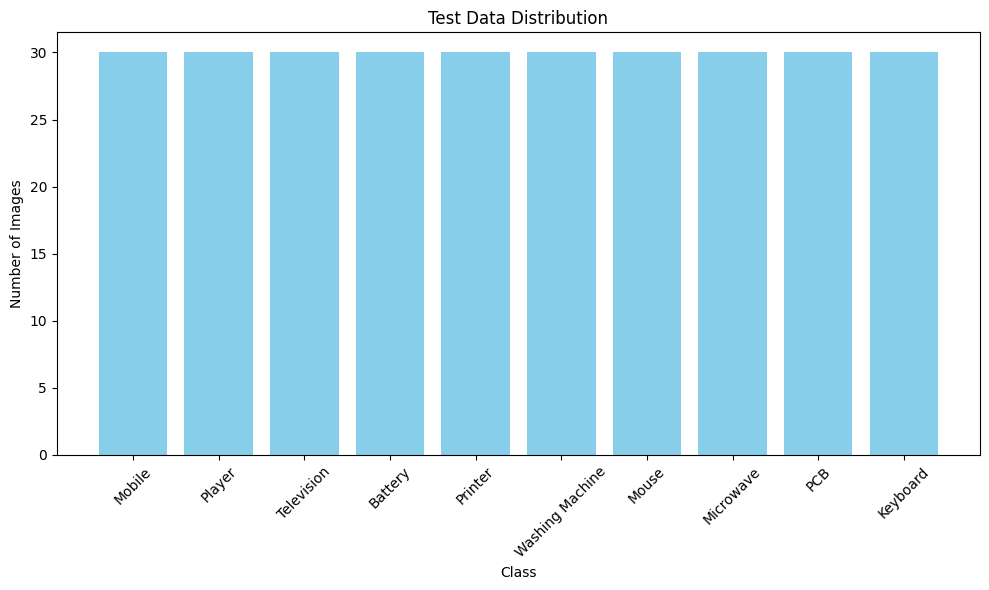

In [26]:
plot_class_distribution_from_dataset(datatrain, class_names, "Training Data Distribution")
plot_class_distribution_from_dataset(datavalid, class_names, "Validation Data Distribution")
plot_class_distribution_from_dataset(datatest, class_names, "Test Data Distribution")


In [27]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

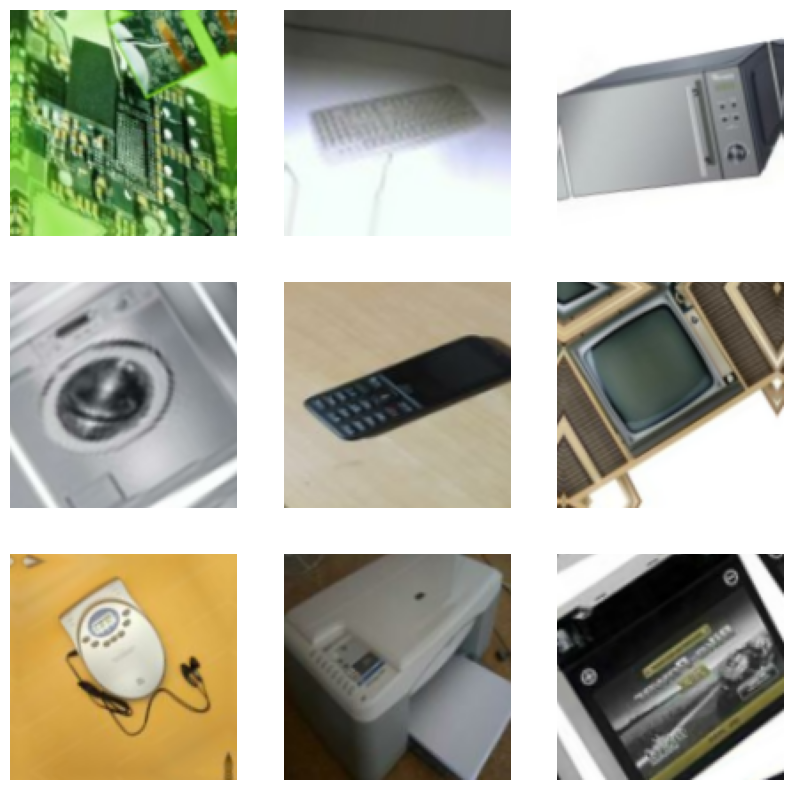

In [33]:
for images, _ in datatrain.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        augmented_img = data_augmentation(images)[i].numpy().astype("uint8")
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_img)
        plt.axis("off")
    break


In [28]:
base_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [29]:
print("Total layers:", len(base_model.layers))
print("Trainable layers:", len([l for l in base_model.layers if l.trainable]))


Total layers: 270
Trainable layers: 170


In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(128, 128, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['Accuracy'])

In [31]:
# Define an EarlyStopping callback to stop training when validation loss stops improving
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',            # Metric to monitor (validation loss here)
    patience=3,                   # Number of epochs to wait after last improvement before stopping
    restore_best_weights=True     # After stopping, restore the model weights from the epoch with the best val_loss
)

In [38]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.keras",               # Filepath to save the best model
    monitor="val_loss",            # Metric to monitor
    save_best_only=True,           # Save only the best weights
    save_weights_only=False,       # Save the entire model (set to True to save just weights)
    mode="min",                    # Looking to minimize validation loss
    verbose=1
)



In [39]:
# Set the number of epochs to train the model
epochs = 15

# Train the model on the training dataset 'datatrain'
history = model.fit(
    datatrain,                      # Training data generator or dataset
    validation_data=datavalid,      # Validation data generator or dataset
    epochs=epochs,                  # Number of training epochs
    callbacks=[early, checkpoint]               # List of callbacks to apply during training (e.g., early stopping)
)

Epoch 1/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - Accuracy: 0.9623 - loss: 0.1615
Epoch 1: val_loss improved from inf to 0.17367, saving model to best_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - Accuracy: 0.9623 - loss: 0.1614 - val_Accuracy: 0.9567 - val_loss: 0.1737
Epoch 2/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - Accuracy: 0.9649 - loss: 0.1363
Epoch 2: val_loss improved from 0.17367 to 0.16377, saving model to best_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - Accuracy: 0.9649 - loss: 0.1363 - val_Accuracy: 0.9533 - val_loss: 0.1638
Epoch 3/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - Accuracy: 0.9669 - loss: 0.1166
Epoch 3: val_loss improved from 0.16377 to 0.15371, saving model to best_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - Accuracy: 0.9669 - loss: 0.1165 - val_Accuracy: 0.9533 - val_loss: 0.1537
Epoch 4/15
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - Accuracy: 0.9734 - loss: 0.1143
Epoch 4: val_loss did not improve from 0.15371
75/75 ━━━━━━━━━━━━━━━━

In [57]:

# datatrain_b16 = datatrain.unbatch().batch(16)
# datavalid_b16 = datavalid.unbatch().batch(16)

# # Set the number of epochs
# epochs = 3

# # Train the model with batch size 16
# history = model.fit(
#     datatrain_b16,
#     validation_data=datavalid_b16,
#     epochs=epochs,
#     callbacks=[early, checkpoint]
# )


In [56]:
# # Re-batch your datasets to batch size 64
# datatrain_b64 = datatrain.unbatch().batch(64)
# datavalid_b64 = datavalid.unbatch().batch(64)

# # Set the number of epochs
# epochs = 3

# # Train the model
# history = model.fit(
#     datatrain_b64,
#     validation_data=datavalid_b64,
#     epochs=epochs,
#     callbacks=[early, checkpoint]
# )


In [58]:
model.summary() # Print the architecture summary of the  model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 4, 4, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,932,122 (22.63 MB)

 Trainable params: 5,168,458 (19.72 MB)

 Non-trainable params: 763,664 (2.91 MB)

In [59]:
print("Trainable params:", np.sum([np.prod(v.shape) for v in model.trainable_variables]))
print("Non-trainable params:", np.sum([np.prod(v.shape) for v in model.non_trainable_variables]))


Trainable params: 5168458
Non-trainable params: 763702


In [60]:
base_model.summary() # Print the architecture summary of the base model

Model: "efficientnetv2-b0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 64, 64,    │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 64, 64,    │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 32, 32,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 32, 32,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 32, 32,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 32, 32,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 32, 32,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 32, 32,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 32, 32,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 32, 32,    │          0 │ block2b_expand_b

 Total params: 5,919,312 (22.58 MB)

 Trainable params: 5,155,648 (19.67 MB)

 Non-trainable params: 763,664 (2.91 MB)

In [61]:
trainable_count = len([l for l in base_model.layers if l.trainable])
non_trainable_count = len([l for l in base_model.layers if not l.trainable])

print(f"Trainable layers: {trainable_count}")
print(f"Non-trainable layers: {non_trainable_count}")


Trainable layers: 170
Non-trainable layers: 100


In [62]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']  # 👈 lowercase
)


In [63]:
acc = history.history['Accuracy']
val_acc = history.history['val_Accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


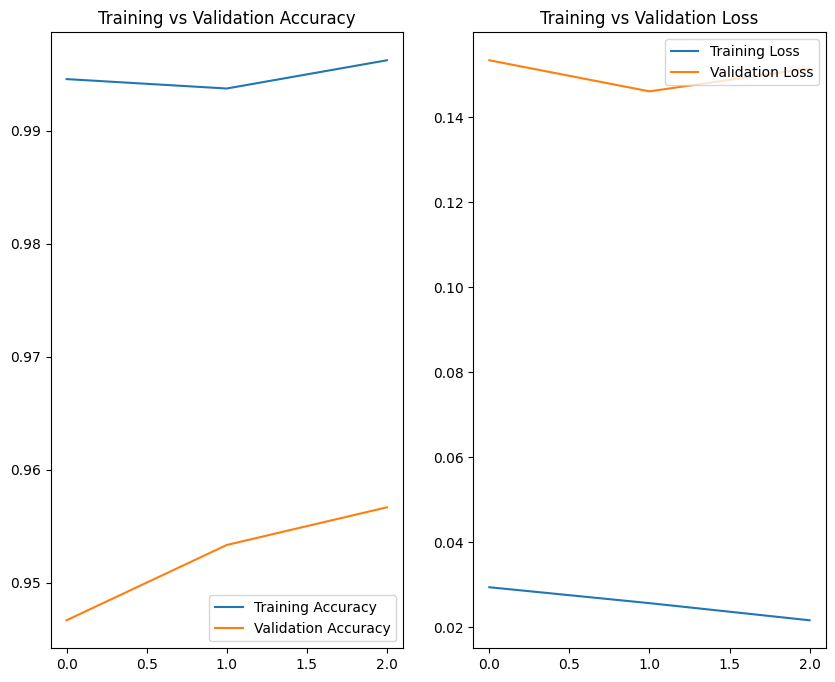

In [64]:
epochs_range = range(len(acc))              # X-axis range based on number of epochs

plt.figure(figsize=(10, 8))                 # Set overall figure size

plt.subplot(1, 2, 1)                        # 1 row, 2 columns, position 1
plt.plot(epochs_range, acc, label='Training Accuracy')       # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy') # Plot validation accuracy
plt.legend(loc='lower right')              # Show legend at lower right
plt.title('Training vs Validation Accuracy') # Set title for accuracy plot

plt.subplot(1, 2, 2)                        # 1 row, 2 columns, position 2
plt.plot(epochs_range, loss, label='Training Loss')          # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')    # Plot validation loss
plt.legend(loc='upper right')              # Show legend at upper right
plt.title('Training vs Validation Loss')    # Set title for loss plot

plt.show()                                  # Display the plots

In [65]:
loss, accuracy = model.evaluate(datatest)
print(f'Test accuracy is{accuracy:.4f}, Test loss is {loss:.4f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 575ms/step - accuracy: 0.9579 - loss: 0.1239
Test accuracy is0.9633, Test loss is 0.1190


In [66]:
### Evaluate Model Performance on Test Data using Confusion Matrix and Classification Report

# Extract true labels from all batches
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 891ms/step
[[28  0  0  0  0  2  0  0  0  0]
 [ 2 28  0  0  0  0  0  0  0  0]
 [ 0  0 30  0  0  0  0  0  0  0]
 [ 0  0  0 29  0  1  0  0  0  0]
 [ 0  0  0  0 30  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0]
 [ 1  0  1  0  1  0 27  0  0  0]
 [ 1  0  0  0  0  0  0 29  0  0]
 [ 0  0  1  1  0  0  0  0 28  0]
 [ 0  0  0  0  0  0  0  0  0 30]]
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        30
           1       1.00      0.93      0.97        30
           2       0.94      1.00      0.97        30
           3       0.97      0.97      0.97        30
           4       0.97      1.00      0.98        30
           5       0.91      1.00      0.95        30
           6       1.00      0.90      0.95        30
           7       1.00      0.97      0.98        30
           8       1.00      0.93      0.97        30
           9       1.00      1.00      1.00        30

    accuracy                   

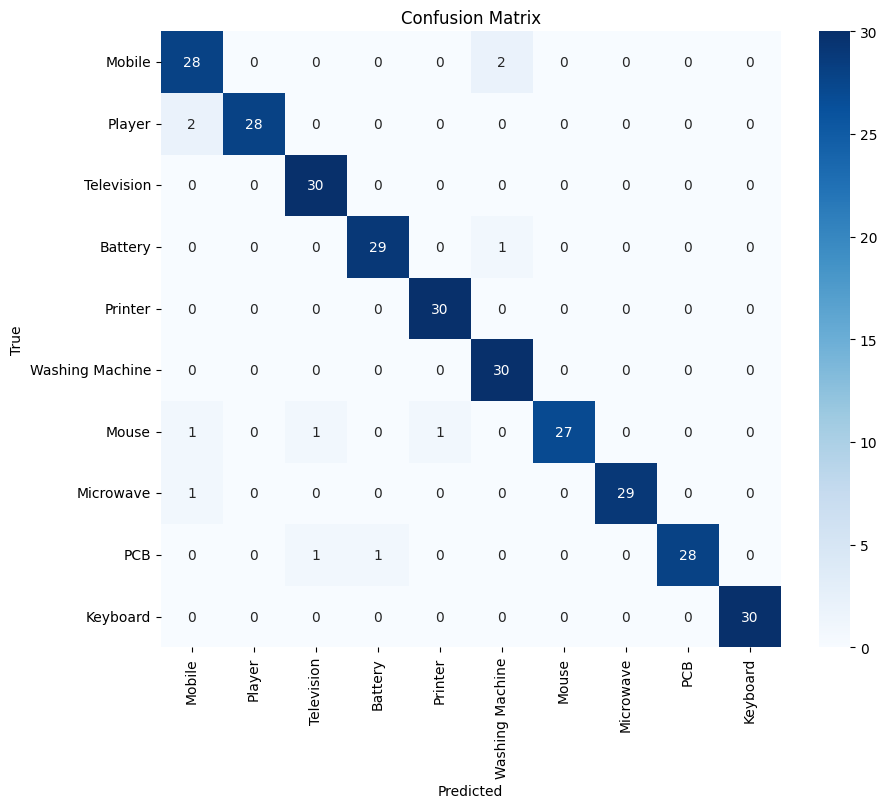

In [67]:
### Plot Confusion Matrix as Heatmap for Better Visualization

cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()                                                                # Display the plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


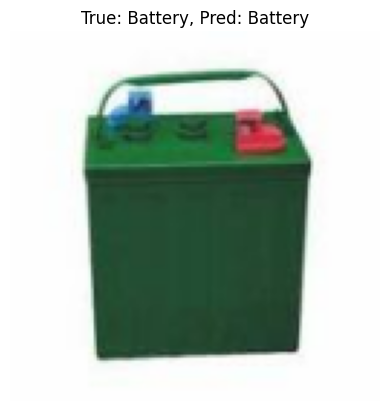

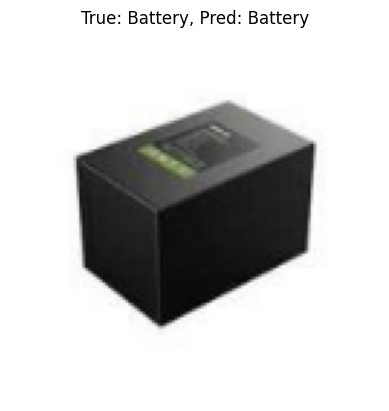

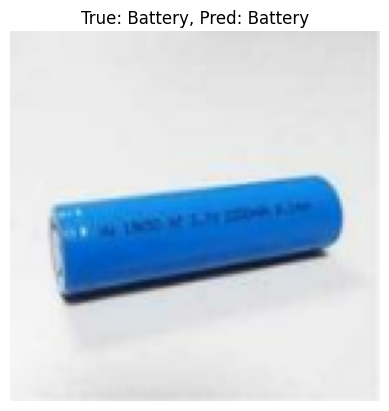

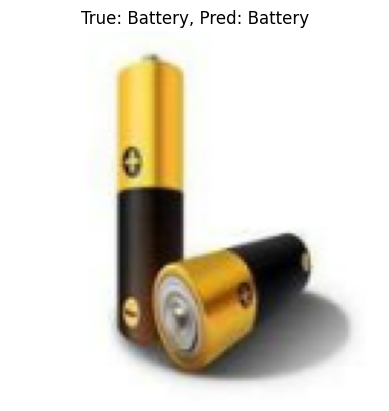

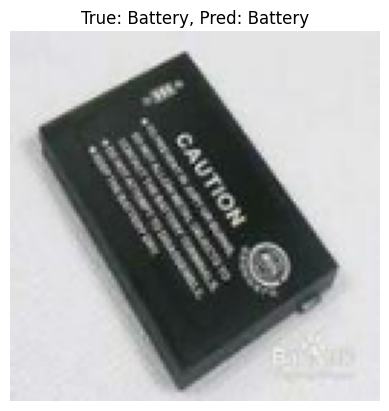

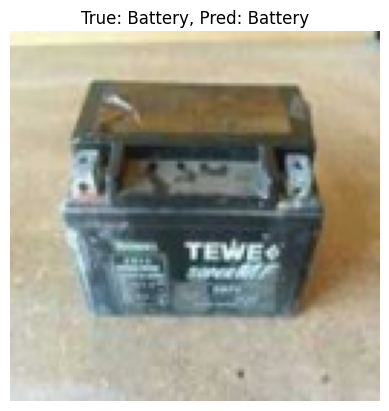

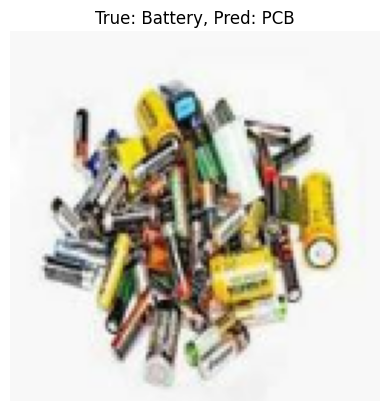

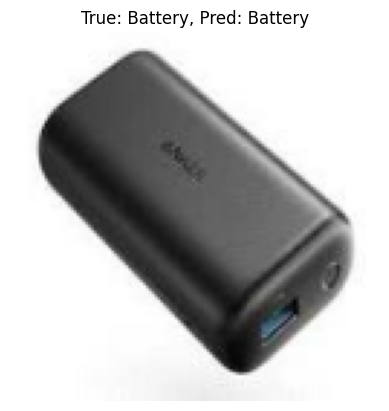

In [68]:
### Display Sample Predictions: True Labels vs Predicted Labels

class_names = datatest.class_names                                           # Get class names from test dataset

for images, labels in datatest.take(1):                                     # Take one batch from test data
    predictions = model.predict(images)                                     # Predict class probabilities
    pred_labels = tf.argmax(predictions, axis=1)                            # Get predicted class indices

    for i in range(8):                                                      # Display first 8 images from batch
        plt.imshow(images[i].numpy().astype("uint8"))                       # Convert tensor to image
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")  # Title with labels
        plt.axis("off")                                                     # Hide axes
        plt.show()                                                          # Show image

In [69]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Efficient_classify.keras')

In [70]:
# Define your class labels
class_names = ['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']

# Load your Keras model
model = tf.keras.models.load_model('Efficient_classify.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 304 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [71]:
def classify_image(img):
    # Step 1: Resize and convert to array
    img = img.resize((128, 128))
    img_array = np.array(img, dtype=np.float32)

    # Step 2: Preprocess and add batch dimension
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    # Step 3: Predict using the model
    prediction = model.predict(img_array)
    index = np.argmax(prediction)  # Get index of highest score

    # Step 4: Get class name and confidence
    class_name = class_names[index]
    confidence = prediction[0][index]

    return f"Predicted: {class_name} (Confidence: {confidence:.2f})"

In [72]:
# Create a Gradio interface for the classify_image function
iface = gr.Interface(
    fn=classify_image,          # The function to run when input is given
    inputs=gr.Image(type="pil"), # Input component: expects an image as a PIL object
    outputs="text"              # Output component: displays the result as plain text
)

# Launch the Gradio interface, opening a local web app to interact with the model
iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e6c282146bc995eff6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
!gradio deploy

It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`huggingface-cli upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
Uploading...: 100% 133M/133M [00:03<00:00, 39.8MB/s]
Space available at https://huggingface.co/spaces/Shivamjha09/e-waste-classifier


In [16]:
def plot_class_distribution(dataset, title):
    """
    Plots the distribution of classes in a given dataset.

    Args:
        dataset: A TensorFlow dataset from which to extract class information.
        title: The title of the plot.
    """
    # Count the number of images in each class directory under the train folder
    class_counts = Counter()

    # Assuming dataset is loaded using image_dataset_from_directory
    # and has a _flat_shapes attribute or similar way to access class names
    # A more robust way would be to iterate through the dataset or have a separate count
    # based on directory structure if image_dataset_from_directory doesn't easily expose counts.
    # For this example, let's assume we can get class names and we will get counts
    # directly from the file system as done previously.

    # Re-using the counting logic from cell VldITDH9IpB3 for demonstration
    # In a real scenario, you might want to derive counts directly from the dataset object
    # if it's efficient or structure your data loading to easily provide counts.
    import os
    from collections import Counter

    dataset_path = None
    if hasattr(dataset, '_input_dataset') and hasattr(dataset._input_dataset, 'element_spec'):
        # Attempt to get directory path from dataset if possible (this is heuristic)
        # This might not work for all dataset types or loading methods
        try:
            import re
            match = re.search(r"from_tensor_slices\((.*?)\)", str(dataset._input_dataset.element_spec))
            if match:
                dataset_path = match.group(1).strip("'\"")
                # Assume the dataset path is the base directory containing class folders
                if dataset_path.endswith('/train') or dataset_path.endswith('/val') or dataset_path.endswith('/test'):
                    base_path = os.path.dirname(dataset_path)
                    for class_name in os.listdir(dataset_path):
                        class_dir = os.path.join(dataset_path, class_name)
                        if os.path.isdir(class_dir):
                            class_counts[class_name] = len(os.listdir(class_dir))
                else:
                     # If path is not train/val/test assume it's the base directory
                    for class_name in os.listdir(dataset_path):
                        class_dir = os.path.join(dataset_path, class_name)
                        if os.path.isdir(class_dir):
                            class_counts[class_name] = len(os.listdir(class_dir))

        except Exception as e:
            print(f"Could not automatically determine dataset path and counts: {e}")
            print("Please ensure class_counts is populated correctly before calling plot_class_distribution.")
            # Fallback or manual way to populate class_counts is needed here
            # For now, we will rely on the class_counts from the previous execution if available
            # or you would need to pass class_counts to this function

    # If class_counts is still empty, try to get class names and estimate counts
    if not class_counts and hasattr(dataset, 'class_names'):
         print("Using class names from dataset object, counts might be estimates or require manual calculation.")
         class_names_list = dataset.class_names
         # This part needs actual logic to count images per class from the dataset object
         # As iterating through the dataset can be slow, this is left as a placeholder
         # A manual count based on file system is generally more straightforward outside of training loop
         print("Warning: Class counts not calculated automatically. Plot might be inaccurate.")
         # You would need to add logic here to populate class_counts based on dataset content


    # Prepare data for plotting
    class_names = list(class_counts.keys())  # List of class names
    counts = list(class_counts.values())     # Corresponding counts for each class


    # Create the bar plot
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.bar(class_names, counts, color='skyblue')  # Draw bars with class counts
    plt.xlabel("Class")  # X-axis label
    plt.ylabel("Number of Items")  # Y-axis label
    plt.title(title)  # Plot title
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()  # Display the plot